# Task 6 : 评估二分类分类性能
实验结果下载地址：https://huggingface.co/datasets/JimXie/IIoTset/resolve/main/performance.tar.gz

In [1]:
import os,json,sys,logging
sys.path.append("./share")
sys.path.append("./common")
import pandas as pd
import json
from tqdm.notebook import tqdm
from IoTCommon import CIoTCommon
from SHSample import CSHSample
from SHDataProcess import CSHDataProcess
from Config import g_data_root
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
warnings.simplefilter("ignore")
g_token_root = "%stoken/"%g_data_root
g_feature_root = "%s/features"%g_data_root
g_result_root = "%sresult"%g_data_root

In [2]:
def show_total(df_result):
    df_tmp = df_result
    df_long = pd.melt(df_tmp,id_vars=['model'],value_vars=['recall', 'precision','accuracy','f1_score'],var_name='metric', value_name='value')
    sns.barplot(x='metric', y='value',hue='model',orient='v',ci=None,data=df_long)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.110), ncol=4)
    plt.xlabel('Metric', fontsize=10)
    plt.ylabel('Metric value', fontsize=10)
    plt.title('Performance', fontsize=12)
    plt.show()
    
def show_bar(attack,df_tmp,hue):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    sns.barplot(x='ratio', y='recall',hue=hue,orient='v',ci=None,data=df_tmp,ax=axes[0,0])
    sns.barplot(x='ratio', y='precision',hue=hue,orient='v',ci=None,data=df_tmp,ax=axes[0,1])
    sns.barplot(x='ratio', y='accuracy',hue=hue,orient='v',ci=None,data=df_tmp,ax=axes[1,0])
    sns.barplot(x='ratio', y='f1_score',hue=hue,orient='v',ci=None,data=df_tmp,ax=axes[1,1])
    axes[0,0].set_title("Recall")
    axes[0,0].set_xlabel('Noise ratio', fontsize=10)
    axes[0,0].set_ylabel('Metric value', fontsize=10)
    axes[0,1].set_title("Precision")
    axes[0,1].set_xlabel('Noise ratio', fontsize=10)
    axes[0,1].set_ylabel('Metric value', fontsize=10)
    axes[1,0].set_title("Accuracy")
    axes[1,0].set_xlabel('Noise ratio', fontsize=10)
    axes[1,0].set_ylabel('Metric value', fontsize=10)
    axes[1,1].set_title("F1_score")
    axes[1,1].set_xlabel('Noise ratio', fontsize=10)
    axes[1,1].set_ylabel('Metric value', fontsize=10)
    
    if len( axes[0,0].legend().get_texts()) == 1:
        axes[0,0].legend().set_visible(False) 
    if len( axes[0,1].legend().get_texts()) == 1:
        axes[0,1].legend().set_visible(False) 
    if len( axes[1,0].legend().get_texts()) == 1:
        axes[1,0].legend().set_visible(False) 
    if len( axes[1,1].legend().get_texts()) == 1:
        axes[1,1].legend().set_visible(False)

    axes[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    axes[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    axes[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    axes[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    
    plt.tight_layout()
    plt.show()
    
def show_line(attack,df_tmp,hue):
    fig, axes = plt.subplots(2, 2, figsize=(14, 6))
    sns.lineplot(x='ratio', y='recall',hue=hue,ci=None,data=df_tmp,ax=axes[0,0])
    sns.lineplot(x='ratio', y='precision',hue=hue,ci=None,data=df_tmp,ax=axes[0,1])
    sns.lineplot(x='ratio', y='accuracy',hue=hue,ci=None,data=df_tmp,ax=axes[1,0])
    sns.lineplot(x='ratio', y='f1_score',hue=hue,ci=None,data=df_tmp,ax=axes[1,1])
    axes[0,0].set_title("Recall")
    axes[0,0].set_xlabel('Noise ratio', fontsize=10)
    axes[0,0].set_ylabel('Metric value', fontsize=10)
    axes[0,1].set_title("Precision")
    axes[0,1].set_xlabel('Noise ratio', fontsize=10)
    axes[0,1].set_ylabel('Metric value', fontsize=10)
    axes[1,0].set_title("Accuracy")
    axes[1,0].set_xlabel('Noise ratio', fontsize=10)
    axes[1,0].set_ylabel('Metric value', fontsize=10)
    axes[1,1].set_title("F1_score")
    axes[1,1].set_xlabel('Noise ratio', fontsize=10)
    axes[1,1].set_ylabel('Metric value', fontsize=10)
    
    axes[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
    axes[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
    axes[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
    axes[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
    if len( axes[0,0].legend().get_texts()) == 1:
        axes[0,0].legend().set_visible(False) 
    if len( axes[0,1].legend().get_texts()) == 1:
        axes[0,1].legend().set_visible(False) 
    if len( axes[1,0].legend().get_texts()) == 1:
        axes[1,0].legend().set_visible(False) 
    if len( axes[1,1].legend().get_texts()) == 1:
        axes[1,1].legend().set_visible(False)
    plt.tight_layout()
    plt.show()

In [3]:
df_session = pd.read_csv("./IIoTSet/result/二分类-原始46个特征.csv")
df_session['kind'] = "46-Features"
df_coap = pd.read_csv("./IIoTSet/result/二分类-COAP.csv")
df_coap['kind'] = "COAP"
df_sspe = pd.read_csv("./IIoTSet/result/二分类-SSPE.csv")
df_sspe['kind'] = "SSPE"
df_result = pd.concat([df_session,df_coap,df_sspe],ignore_index=True).reset_index(drop=True)
df_result['attack'] = df_result['attack'].fillna("All")
df_result['ratio'] = (df_result['ratio']*100).astype(int)
df_result = df_result[['model','recall','accuracy','precision','auc','f1_score','ratio','kind','attack']]

# 原始的46个特征方式

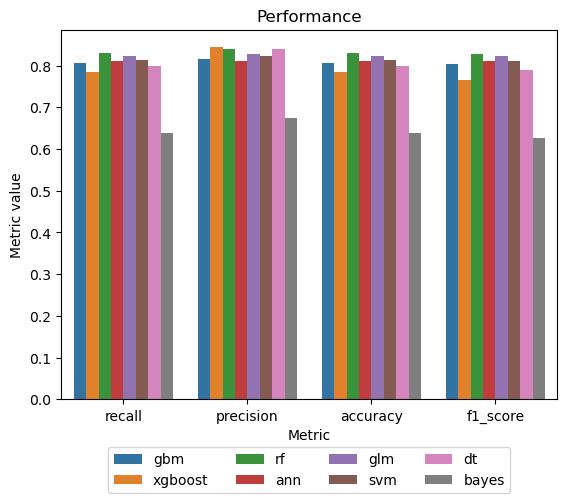

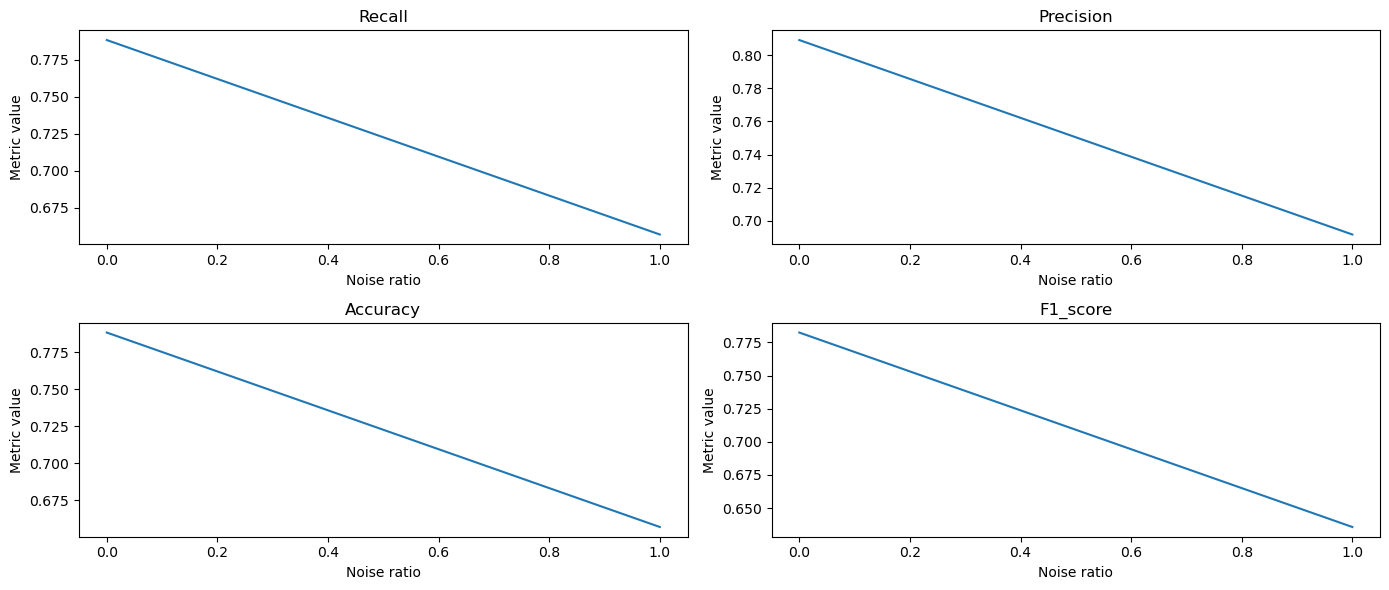

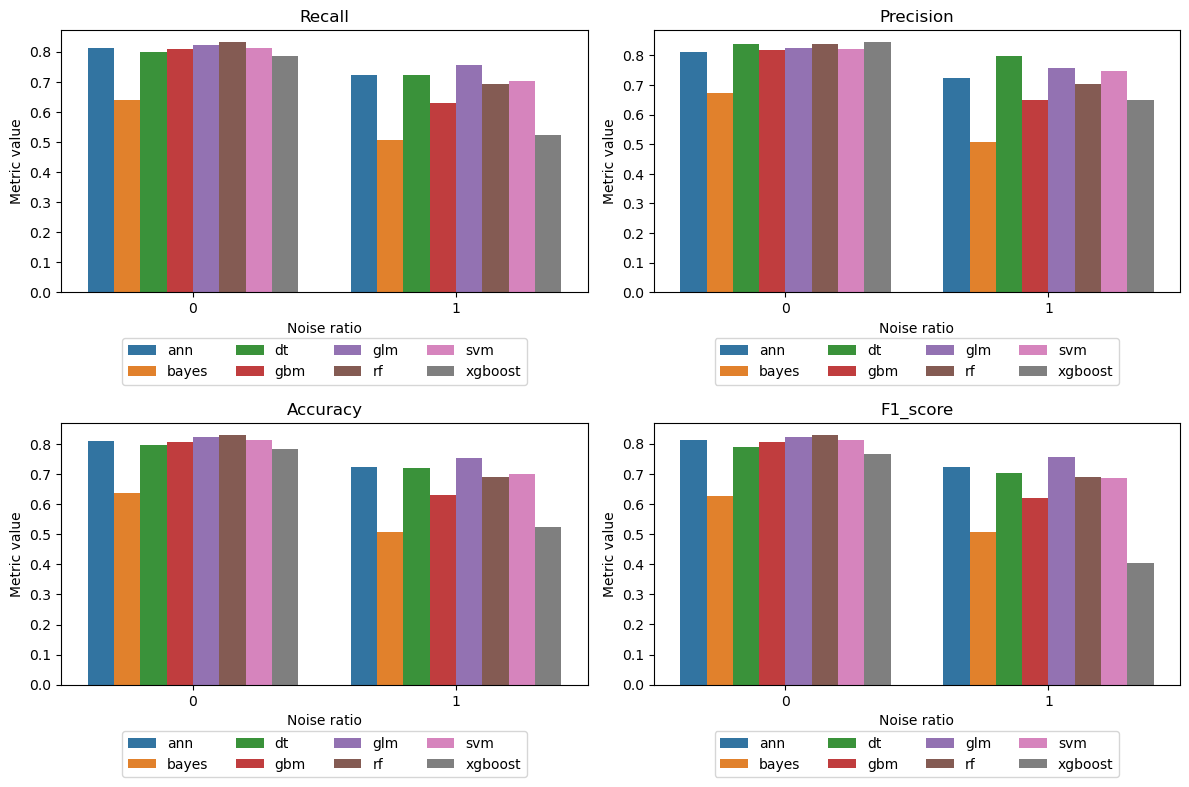

In [4]:
# 不加噪音
df_tmp = df_result[df_result['kind']=='46-Features'].reset_index(drop=True)
df_tmp = df_tmp[df_tmp['ratio']==0].reset_index(drop=True)
df_tmp = df_tmp.sort_values(by=["f1_score"],ascending=False).reset_index(drop=True)
show_total(df_tmp)

# 加噪音模型的平均性能
df_tmp = df_result[df_result['kind']=='46-Features'].reset_index(drop=True)
del df_tmp['attack']
del df_tmp['model']
df_tmp = df_tmp.groupby(['kind','ratio']).mean().reset_index()
show_line("All",df_tmp,"kind")

#加噪音不同模型的性能
df_tmp = df_result[df_result['kind']=='46-Features'].reset_index(drop=True)
del df_tmp['attack']
df_tmp = df_tmp.groupby(['model','kind','ratio']).mean().reset_index()
show_bar("All",df_tmp,"model")

# 使用COAP和SSPE

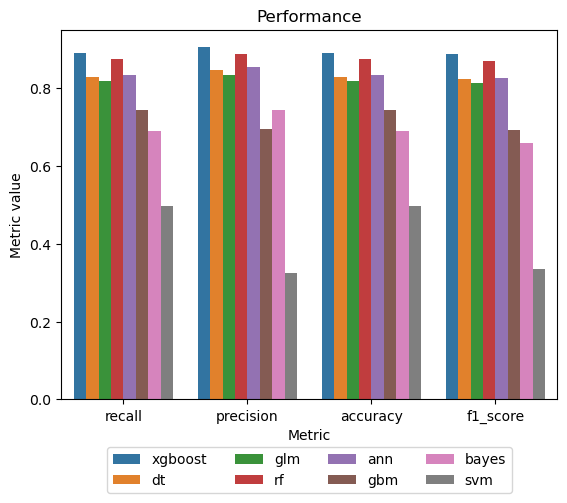

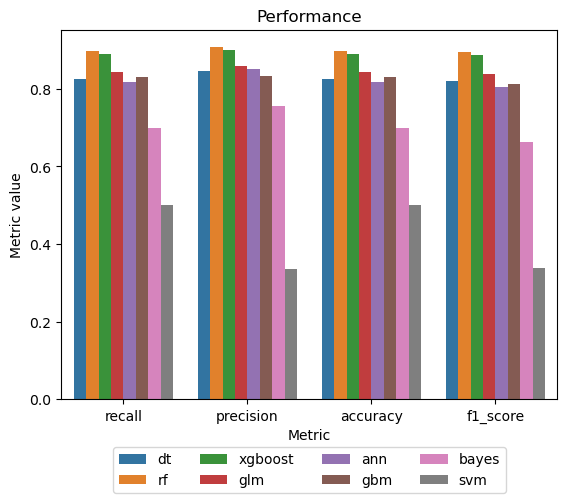

,recall,accuracy,precision,auc,f1_score,ratio
kind,,,,,,
46-Features,0.77628328,0.77628328,0.79850122,0.77679300,0.76915853,0.09090909
COAP,0.76832704,0.76832704,0.75836928,0.77041194,0.73362122,0.09090909
SSPE,0.78167275,0.78167275,0.78130292,0.78283615,0.74933863,0.09090909


In [5]:
# COAP不加噪音
df_tmp = df_result[df_result['kind']=='COAP'].reset_index(drop=True)
df_tmp = df_tmp[df_tmp['ratio']==0].reset_index(drop=True)
df_tmp = df_tmp.sort_values(by=["f1_score"],ascending=False).reset_index(drop=True)
show_total(df_tmp)
# SSPE 不加噪音
df_tmp = df_result[df_result['kind']=='SSPE'].reset_index(drop=True)
df_tmp = df_tmp[df_tmp['ratio']==0].reset_index(drop=True)
df_tmp = df_tmp.sort_values(by=["f1_score"],ascending=False).reset_index(drop=True)
show_total(df_tmp)
df_tmp = df_result.copy(deep=True)
del df_tmp['model']
del df_tmp['attack']
#加噪音的平均性能
df_tmp = df_tmp.groupby(['kind']).mean()
df_tmp

# Session，COAP和SSPE的对比

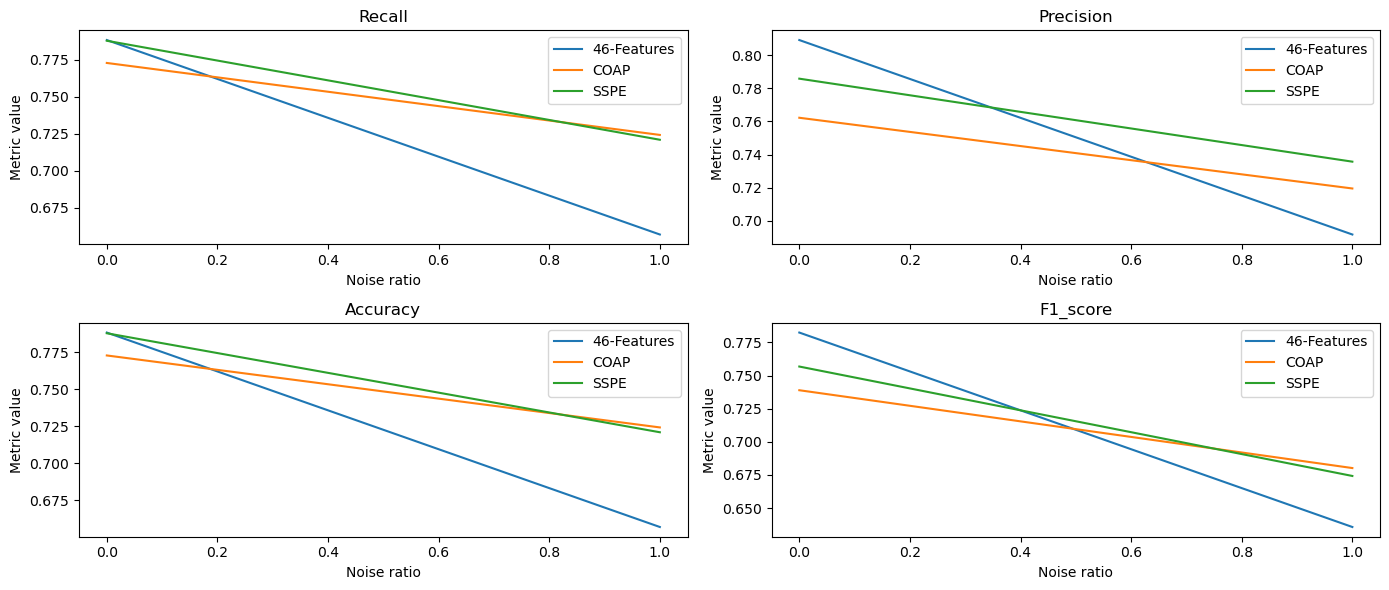

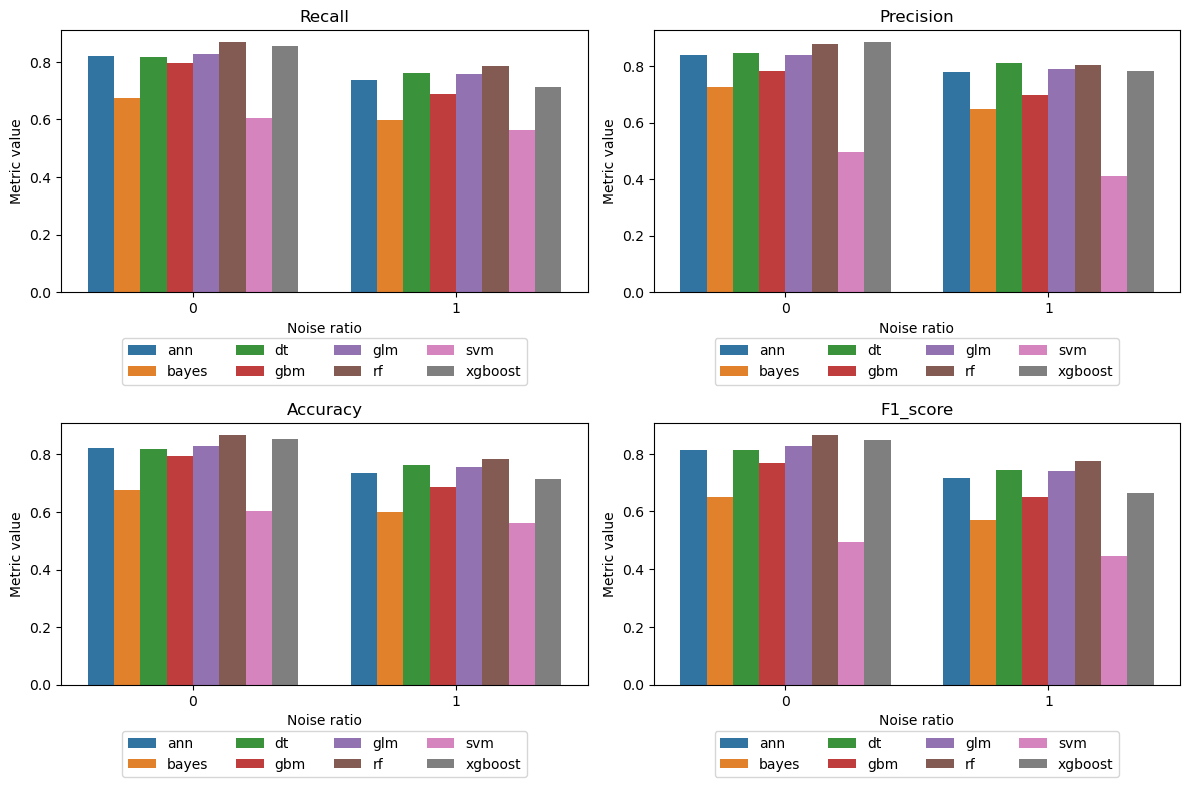

,model,kind,ratio,recall,accuracy,precision,auc,f1_score
0,ann,46-Features,0,0.81119488,0.81119488,0.81121902,0.81113316,0.81117793
1,ann,46-Features,1,0.72292029,0.72292029,0.72296494,0.72279668,0.72286184
2,ann,COAP,0,0.83400179,0.83400179,0.85474321,0.83470156,0.82781985
3,ann,COAP,1,0.77565133,0.77565133,0.81730491,0.77669378,0.75735556
4,ann,SSPE,0,0.81652947,0.81652947,0.85106652,0.81702380,0.80449490
5,ann,SSPE,1,0.71006356,0.71006356,0.79616271,0.71076444,0.66642340
6,bayes,46-Features,0,0.63829929,0.63829929,0.67326416,0.63974960,0.62717887
7,bayes,46-Features,1,0.50763580,0.50763580,0.50771559,0.50767125,0.50763989
8,bayes,COAP,0,0.69041069,0.69041069,0.74518707,0.69233543,0.65922035
9,bayes,COAP,1,0.65957515,0.65957515,0.71693076,0.66339167,0.62653510


In [6]:
df_tmp = df_result.copy(deep=True)
del df_tmp['attack']
df_tmp = df_tmp.sort_values(by='ratio').reset_index(drop=True)
df_tmp = df_tmp.groupby(['model','kind','ratio']).mean().reset_index()
#模型的平均性能对比
show_line("All",df_tmp,"kind")
#各个模型的性能对比
show_bar("All",df_tmp,"model")
#显示详细
display(df_tmp)